In [179]:
colab = false #If running notebooks in Google Colab, set to true. If running Julia locally, change to false
if colab == true
  import Pkg

  Pkg.add("Distributions")
  Pkg.add("PyPlot")
  Pkg.add("LinearAlgebra")
  Pkg.add("Random")
  Pkg.add("QuadGK")
  Pkg.add("Git")

  # Load packages to be used. These packages must be installed first.

  using Git

  if isdir("TutorialCNS2025")
    # Remove the existing directory
    rm("TutorialCNS2025", recursive=true, force=true)
  end

  run(`git clone "https://github.com/chrismkkim/TutorialCNS2025.git"`)
  push!(LOAD_PATH, "/content/TutorialCNS2025")
  rep_path = "/content/TutorialCNS2025/"

else
  rep_path = ""

end

""

In [180]:
using PyPlot
using Random
using LinearAlgebra
using Distributions

# 1. Set up a recurrent network of rate units





In [181]:
# Read in relevant model parameters
include(rep_path*"src_part1/param.jl");

## 1.1 Initialize recurrent weights

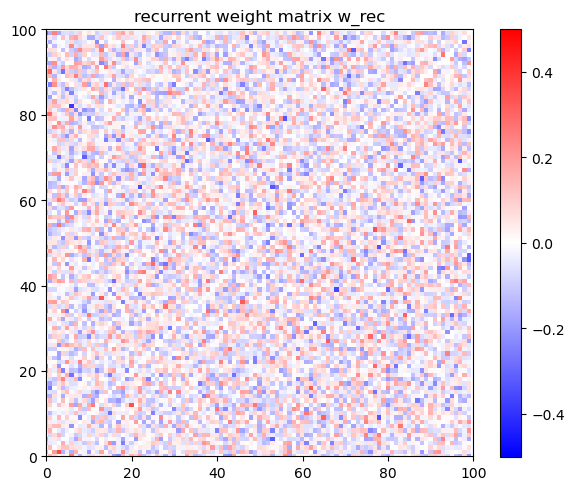

In [182]:
include(rep_path*"src_part1/genWeights.jl")
w_rec = genWeights(p.Ncells,0,1)/sqrt(p.Ncells)
w_rec_init = copy(w_rec) # save a copy of the initialized recurrent weights

# Plot recurrent weight matrix
fig, ax = subplots(figsize=(6, 6))

# Custom normalization centered at 0
norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=0.5)
cax = ax.imshow(w_rec, cmap="bwr", norm=norm)
colorbar(cax, shrink=0.75)

xlim(0,p.Ncells)
ylim(0,p.Ncells)
title("recurrent weight matrix w_rec")

# Show plot
tight_layout()
show()

## 1.2 Generate target rates

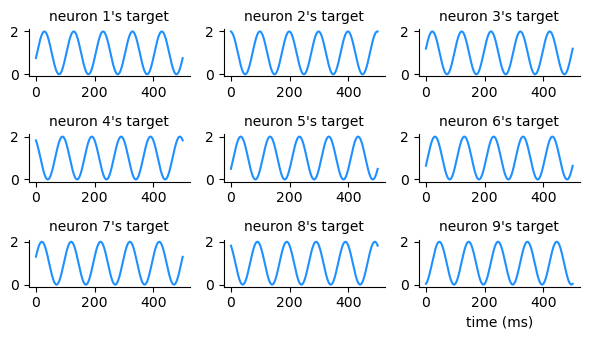

In [183]:
include(rep_path*"src_part1/generate_target_rates.jl")
r_targ = generate_target_rates(p)
t_targ = vec(1:p.train_duration/p.dt) .* p.dt

# show target activity patterns
figure(figsize=(6,3.5))
for ci = 1:9
    ax = subplot(3,3,ci)
    #plot(t[Int((p.stim_off+1)/p.dt):end], r_targ[Int((p.stim_off+1)/p.dt):end,ci], color="dodgerblue")
    plot(t_targ, r_targ[Int((p.stim_off)/p.dt)+1:end,ci], color="dodgerblue")

    title("neuron $(ci)'s target", fontsize=10)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
xlabel("time (ms)")
tight_layout()

PyPlot.display_figs()

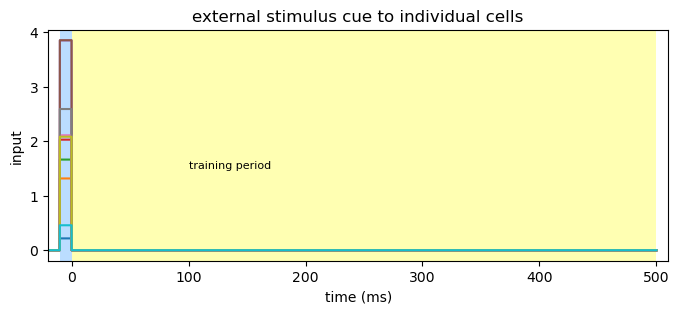

In [184]:
# define stimulus to trigger response in cells
scalar = 2
stim = 2*(2*rand(Int(p.Ncells))); #generate stimulus magnitudes for each cell
#stim = scalar * LogNormal(0, 1)

I_ext = zeros(p.Nsteps,p.Ncells) #initialize external input
for ti = 1:p.Nsteps
    #set external input
    if ti >= Int(p.stim_on/p.dt) && ti <= Int(p.stim_off/p.dt)
            I_ext[ti,:] .= stim;
    else
            I_ext[ti,:] .= 0
    end
end

figure(figsize=(8,3))
title("external stimulus cue to individual cells")
t = vec(1:p.Nsteps) .* p.dt .- p.stim_off

plot(t[Int(p.stim_on):end], I_ext[Int(p.stim_on):end, 1:10]) #display external stimulus to a subset of cells prior to training
#annotate("pre-stim", (0,1.0), fontsize=8)
annotate("training period", (100,1.5), fontsize=8)

axvspan(p.stim_on-p.stim_off, p.stim_off-p.stim_off , color="dodgerblue", alpha=0.3, ec="None")
axvspan(p.stim_off-p.stim_off, p.train_time-p.stim_off, color="yellow", alpha=0.3, ec="None")
#xlim(0,p.train_duration)
ylabel("input")
xlabel("time (ms)")
xlim(-20,510)
show()

# 2. Simulate and train a rate-based RNN

The dynamics of our network evolve according to the equation below:
\begin{gathered}
    \Large{\tau \frac{dr}{dt} = -r + \phi(w_{rec} \cdot r + I_{ext})}
\end{gathered}

By applying recursive least squares (RLS) as a learning rule, we train the recurrent input
$w_{rec} r$.

In [185]:
# import functions required for training
include(rep_path*"src_part1/activation_functions.jl") #Loads activation function called as F.
include(rep_path*"src_part1/rls_train.jl")

rls_train (generic function with 1 method)

In [186]:
# main training function

function train_rate_model(p,w_rec,I_ext)

  # Set parameters and initialize
  x = zeros(p.Nsteps,p.Ncells) #initialize total input to each cell
  r = zeros(p.Nsteps,p.Ncells) #initialize output rate for each cell
  wr = zeros(p.Nsteps,p.Ncells)

    # Initialize regularized inverse correlation matrix
    p.penlambda = 0.5
    P = Dict{Int64,Array{Float64,2}}()
    Px = Dict{Int64, Vector{Int64}}()
    for ci=1:Ncells
        ci_prenum = sum(w_rec[ci,:].!=0);
        ci_preind = w_rec[ci,:].!=0;
        P[ci] = (1.0 / p.penlambda) * I(ci_prenum)  # Using the identity matrix function I(n) instead of eye
        Px[ci] = findall(ci_preind);
    end

  for iloop =1:p.nloop
    println("Loop no. ",iloop)

    start_time = time()

    #compute rate timecourse
    for ti = 2:p.Nsteps

        x[ti-1,:] .= w_rec * r[ti-1,:] .+ I_ext[ti,:] # calculate total input to each neuron (recurrent + external)


        dr = p.dt/p.tau .* (-r[ti-1,:] .+ F(x[ti-1,:], p)) # calculate incremental change in rate dr at timestep ti

        r[ti,:] = r[ti-1,:] .+ dr # update rate for each neuron
        wr[ti,:] = w_rec * r[ti,:] #Compute the training variable

        if ti > Int(p.stim_off/dt)+1 && mod(ti, p.learn_every/p.dt) == 0

           w_rec, P = rls_train(ti, p, r, r_targ, P, Px, w_rec) # apply learning rule to recursively update weights and the per-cell inverse correlation matrix

        end

    end

    # calculate the time for each training loop and assess average correlation between target and output
    elapsed_time = time()-start_time
    correlations = [cor(r_targ[Int(p.stim_off+1/p.dt):end,ci], wr[Int(p.stim_off+1/p.dt):end,ci]) for ci in 1:p.Ncells]
    println("elapsed time: ",elapsed_time, " corr=", mean(correlations))

  end

  return r, w_rec, wr

end

train_rate_model (generic function with 1 method)

In [187]:
r, w_rec, wr = train_rate_model(p, w_rec, I_ext);

Loop no. 1
elapsed time: 0.3155789375305176 corr=0.9352190417876433
Loop no. 2
elapsed time: 0.45064711570739746 corr=0.8784514476275538
Loop no. 3
elapsed time: 0.26340699195861816 corr=0.9827916365074623
Loop no. 4
elapsed time: 0.24345803260803223 corr=0.9482730526161697
Loop no. 5
elapsed time: 0.2948188781738281 corr=0.9669529580337226
Loop no. 6
elapsed time: 0.275209903717041 corr=0.9483275577044178
Loop no. 7
elapsed time: 0.23540997505187988 corr=0.9746045744244164
Loop no. 8
elapsed time: 0.24805998802185059 corr=0.9815259860823198
Loop no. 9
elapsed time: 0.2536768913269043 corr=0.9812350561821986
Loop no. 10
elapsed time: 0.25284600257873535 corr=0.9473459830503504
Loop no. 11
elapsed time: 0.23805809020996094 corr=0.9716614623953487
Loop no. 12
elapsed time: 0.2703521251678467 corr=0.9643507380251531
Loop no. 13
elapsed time: 0.23763799667358398 corr=0.9607665939225459
Loop no. 14
elapsed time: 0.26000094413757324 corr=0.9746435207854072
Loop no. 15
elapsed time: 0.2842750

# 3. Analyze the trained network

## 3.1 Compare per-cell agreement between trained rates and target activity

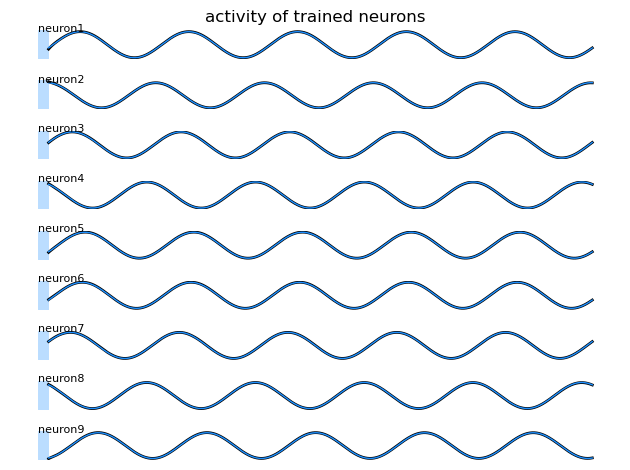

In [188]:
beg_train = Int(p.stim_off/p.dt)+1
stop_train = Int(p.train_time/p.dt)
for ci = 1:9
    subplot(9,1,ci)

    axvspan(-(p.stim_off/p.dt-p.stim_on/p.dt), 0, color="dodgerblue", alpha=0.3, ec="None")
    plot(wr[beg_train:stop_train,ci], lw=2, color="black", label="output")
    plot(r_targ[beg_train:stop_train,ci], lw=1, color="dodgerblue", label="target")
    annotate("neuron$(ci)", ((p.stim_off/p.dt)-1200,2.0), fontsize=8)

    if ci ==1
        title("activity of trained neurons")
        #legend(frameon=false, bbox_to_anchor=(1.2, 1.05),loc="upper right")
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()



## 3.2 Visualize change in trained weights

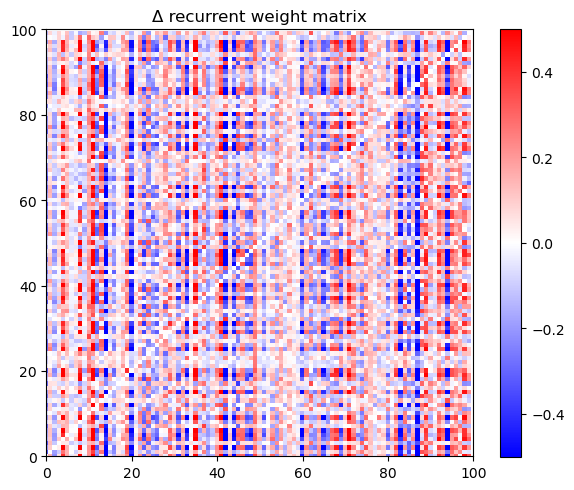

In [189]:
# Plot recurrent weight matrix
fig, ax = subplots(figsize=(6, 6))

delta_w_rec = w_rec .- w_rec_init

# Custom normalization centered at 0
norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=0.5)
cax = ax.imshow(delta_w_rec, cmap="bwr", norm=norm)
colorbar(cax, shrink=0.75)

xlim(0,p.Ncells)
ylim(0,p.Ncells)
title("Δ recurrent weight matrix")

# Show plot
tight_layout()
show()